In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 
import random
import torch
from torch import nn
import torchvision
from torchvision.utils import save_image
import torch.optim as optim
from PIL import Image

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [2]:
root_images="../input/all-dogs/all-dogs/" # images are named like = breednumber_imagenumber.jpg
root_annots="../input/annotation/Annotation/" # annotations are named like = breednumber_breedname/breednumber_imagenumber.jpg

all_images=glob.glob("../input/all-dogs/all-dogs/*") # path for each image
print(f"Total images : {len(all_images)}")

breeds = glob.glob('../input/annotation/Annotation/*')

label_map={}
inverse_label_map={}
annotation=[]

i=0
for b in breeds: 
    annotation+=glob.glob(b+"/*") # path for each annotation
    label_map[b.split("/")[-1]]=i
    inverse_label_map[i]=b.split("/")[-1]
    i+=1
print(f"Total annotation : {len(annotation)}")

annot_map={}
for annot in annotation:
    breednumber=annot.split("/")[-1]
    annot_map[breednumber]=annot
    
print(f"Length of annotation map :{len(annot_map)}")

Total images : 20579
Total annotation : 20580
Length of annotation map :20580


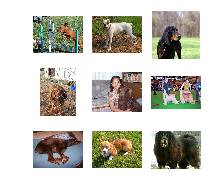

In [3]:
plt.figure(figsize=(3,3))
for i in range(9):
    plt.subplot(3,3,i+1)
    im=Image.open(all_images[i])
    plt.imshow(im)
    plt.axis("off")

In [4]:
class DogDataset(torch.utils.data.Dataset):
    
    def __init__(self,all_images,annot_map,label_map,transform):
        self.all_images=all_images
        self.annot_map=annot_map
        self.label_map=label_map
        self.transform=transform
        
    def __getitem__(self,idx):
        
        impath=self.all_images[idx]
        image=Image.open(impath)
        
        # getting annotations for the image
        annotkey=impath.split("/")[-1].split(".")[0] # breednumber_imagenumber
        annot=self.annot_map[annotkey]
        
        labelkey=annot.split("/")[-2]
        temp=self.label_map[labelkey] # breednumber_breedname
        label=torch.zeros(120)
        label[temp]=1
        
        crop_size=self.getbbox(annot)
        image=image.crop(crop_size)
        
        return self.transform(image),label
        
    def __len__(self):
        return len(self.all_images)
    
 
    def getbbox(self,bpath):
        tree = ET.parse(bpath)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') # reading bound box
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
        return (xmin,ymin,xmax,ymax)

In [5]:
class opt:
    workers=2
    batchsize=128
    imagesize=64
    nz=100
    ngf=64
    ndf=64
    nc=3
    niter=300
    lr=0.0001
    beta1=0.5
    ngpu=1
    cuda=torch.cuda.is_available()
    

mean=0
std=1
transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(64),
        torchvision.transforms.CenterCrop(64),
        torchvision.transforms.ColorJitter(0.1),
        torchvision.transforms.RandomHorizontalFlip(0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((mean,mean,mean),(std,std,std))
    ])

# The dataset
dataset=DogDataset(all_images,annot_map,label_map,transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=opt.batchsize,
                                         shuffle=True, 
                                         num_workers=opt.workers)

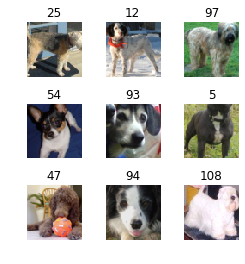

In [6]:
for x,y in dataloader:
    images=x.numpy().transpose(0,2,3,1)
    labels=y.numpy()
    plt.figure(figsize=(4,4))
    plt.subplots_adjust(hspace=0.5)
    for i in range(9):
        plt.subplot(3,3,i+1)        
        plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis("off")
    break

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
nz = opt.nz
ngf = opt.ngf
ndf = opt.ndf
nc = opt.nc
ngpu = opt.ngpu
   
device = torch.device("cuda:0" if opt.cuda else "cpu")

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ylabel=nn.Sequential(
            nn.Linear(120,1000),
            nn.ReLU(True)
        )
        
        self.yz=nn.Sequential(
            nn.Linear(100,200),
            nn.ReLU(True)
        )
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(1200, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf,nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, z,y):
        
        #mapping noise and labe
        z=self.yz(z)
        y=self.ylabel(y)
        
        #mapping concatenated input to the main generator network
        inp=torch.cat([z,y],1)
        inp=inp.view(-1,1200,1,1)
        output = self.main(inp)

        return output

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
            
        self.ylabel=nn.Sequential(
            nn.Linear(120,64*64*1),
            nn.ReLU(True)
        )
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc+1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x,y):
        y=self.ylabel(y)
        y=y.view(-1,1,64,64)
        inp=torch.cat([x,y],1)
        output = self.main(inp)
        
        return output.view(-1, 1).squeeze(1)

In [11]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print("Discriminator and Generator Loaded")

Discriminator and Generator Loaded


In [12]:
criterion = nn.BCELoss()

# noise shape - (batch_size,100)
fixed_noise = torch.randn(opt.batchsize, nz, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

In [13]:
derror_epoch=[]
gerror_epoch=[]
for epoch in range(opt.niter):
# for epoch in range(1):
    derror_iter=0
    gerror_iter=0
    for i, data in enumerate(dataloader, 0):

        # DISCRIMINATOR 
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        breed=data[1].to(device)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu,breed)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz,device=device)
        fake = netG(noise,breed)
        label.fill_(fake_label)
        output = netD(fake.detach(),breed)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        derror_iter+=errD.item()
        optimizerD.step()
        
        # GENERATOR
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake,breed)
        errG = criterion(output, label)
        gerror_iter+=errG.item()
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
#         if(i%70==0 and i!=0):
#             print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
#                   % (epoch, opt.niter, i, len(dataloader),
#                      errD.item(), errG.item()))
            
            
    # accumulate error for each epoch
    derror_epoch.append(derror_iter)
    gerror_epoch.append(gerror_iter)

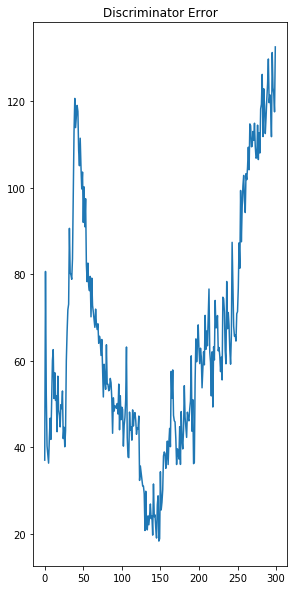

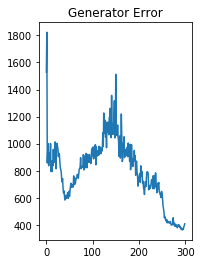

In [14]:
plt.figure(figsize=(10,10))
        
# discriminator loss
plt.subplot(1,2,1)
plt.plot(list(range(len(derror_epoch))),derror_epoch)
plt.title("Discriminator Error")
plt.show()

# generator loss
plt.subplot(1,2,2)
plt.plot(list(range(len(gerror_epoch))),gerror_epoch)
plt.title("Generator Error")
plt.show()

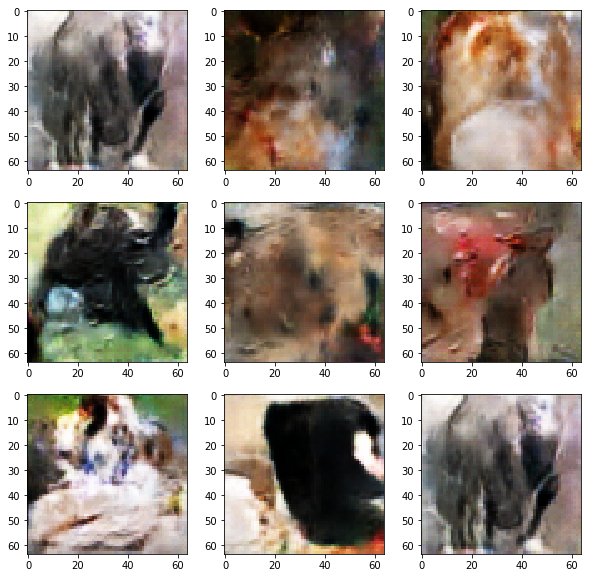

In [15]:
def plot_fake_images():
    gen_z = torch.randn(10, nz, device=device)
    breed=torch.zeros(10,120,device=device)
    for i in range(10):
        x=np.random.randint(0,120)
        breed[i][x]=1
    gen_images = netG(gen_z,breed)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])

plot_fake_images()

In [16]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, device=device)
    breed=torch.zeros(im_batch_size,120,device=device)
    for i in range(im_batch_size):
        x=np.random.randint(0,120)
        breed[i][x]=1
    gen_images = netG(gen_z,breed)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'